# CS6700: Reinforcement Learning
## Programming Assignment 1

Submitted by:
- Archish S (ME20B032)
- Vinayak Gupta (EE20B152)

# Dueling DQN

## Imports

In [1]:
import random
from dataclasses import dataclass
from collections import deque
from itertools import count

import gym
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 10
})
%config InlineBackend.figure_format = 'retina'

import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

## Networks

In [2]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, args):
        super(QNetwork, self).__init__()
        self.args = args
        
        self.fc = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 4*hidden_size),
            nn.ReLU(),
        )
        self.value = nn.Sequential(
            nn.Linear(4*hidden_size, 1)
        )

        self.advantage = nn.Sequential(
            nn.Linear(4*hidden_size, action_size)
        )

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc(x)
        value = self.value(x)
        advantage = self.advantage(x)
        
        if self.args.type == 'type1':
            Q = value + advantage - advantage.mean(dim=1, keepdim=True)
        elif self.args.type == 'type2':
            Q = value + (advantage - torch.max(advantage, dim=1, keepdim=True)[0])
        else:
            raise NotImplementedError(f'Unknown type: {self.args.type}')
        
        return Q
    
    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action = Q.argmax(dim=1)
        return action.item()

In [3]:
class Memory:
    @property
    def size(self):
        return len(self.buffer)

    def __init__(self, size):
        self.buffer = deque(maxlen=size)
    
    def add(self, experience):
        state, action, reward, next_state, done = experience
        state = torch.tensor(state, dtype=torch.float32).detach().cpu().flatten()
        next_state = torch.tensor(next_state, dtype=torch.float32).detach().cpu().flatten()
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size, continuous=True):
        batch_size = min(batch_size, self.size)

        if continuous:
            idx = np.random.randint(0, self.size - batch_size)
            return [self.buffer[i] for i in range(idx, idx + batch_size)]
        else:
            idx = np.random.choice(range(self.size), batch_size, replace=False)
            return [self.buffer[i] for i in idx]

    def clear(self):
        self.buffer.clear()

In [4]:
class Agent:
    def __init__(self, args, type):
        self.args = args
        self.args.type = type
        self.env = gym.make(args.env + '-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.memory = Memory(args.replay_size)

        self.online_Qnetwork = QNetwork(self.state_size, self.action_size, self.args.hidden_size, self.args).to(self.args.device)
        self.init_weights = self.online_Qnetwork.state_dict().copy()
        self.target_Qnetwork = QNetwork(self.state_size, self.action_size, self.args.hidden_size, self.args).to(self.args.device)
        self.target_Qnetwork.load_state_dict(self.online_Qnetwork.state_dict())

        self.optimizer = optim.Adam(self.online_Qnetwork.parameters(), lr=self.args.lr)

    def learn(self, batch):
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)
        batch_state = torch.stack(batch_state, dim=0).float().to(self.args.device)
        batch_action = torch.tensor(batch_action, dtype=torch.long).unsqueeze(1).to(self.args.device)
        batch_reward = torch.tensor(batch_reward, dtype=torch.float).unsqueeze(1).to(self.args.device)
        batch_next_state = torch.stack(batch_next_state, dim=0).float().to(self.args.device)
        batch_done = torch.tensor(batch_done, dtype=torch.long).unsqueeze(1).to(self.args.device)

        with torch.no_grad():
            onlineQ_next = self.online_Qnetwork(batch_next_state)
            targetQ_next = self.target_Qnetwork(batch_next_state)
            online_action = onlineQ_next.argmax(dim=1, keepdim=True)
            y = batch_reward + self.args.gamma * targetQ_next.gather(1, online_action) * (1 - batch_done)

        loss = F.mse_loss(self.online_Qnetwork(batch_state).gather(1, batch_action), y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def train(self):

        run_rewards = []    
        for run in tqdm.trange(self.args.num_runs, desc='Runs'):
            self.online_Qnetwork.init_weights()
            self.target_Qnetwork.load_state_dict(self.online_Qnetwork.state_dict())
            self.optimizer = optim.Adam(self.online_Qnetwork.parameters(), lr=self.args.lr)

            self.online_Qnetwork.train()
            self.target_Qnetwork.eval()

            learn_steps = 0
            episode_rewards = []
            for episode in tqdm.trange(self.args.num_episodes, desc='Episodes', leave=False):
                state = self.env.reset()
                total_reward = 0
                
                for t in count():
                    # epsilon = max(self.args.epsilon_min, self.args.epsilon_max**t)
                    epsilon = max(self.args.epsilon_min, self.args.epsilon_max - (self.args.epsilon_max - self.args.epsilon_min) * t / self.args.num_episodes)
                    if random.random() < epsilon:
                        action = self.env.action_space.sample()
                    else:
                        action = self.online_Qnetwork.select_action(torch.tensor(state, dtype=torch.float32).to(self.args.device).unsqueeze(0))

                    next_state, reward, done, _ = self.env.step(action)
                    total_reward = reward + self.args.gamma * total_reward
                    
                    self.memory.add((state, action, reward, next_state, done))  

                    if self.memory.size > self.args.batch_size:
                        learn_steps += 1
                        if learn_steps % self.args.update_steps == 0:
                            self.target_Qnetwork.load_state_dict(self.online_Qnetwork.state_dict())

                        batch = self.memory.sample(self.args.batch_size)
                        self.learn(batch)

                    if done or t > self.args.max_steps:
                        break        
                    state = next_state
                
                episode_rewards.append(total_reward)
            run_rewards.append(episode_rewards)

        return run_rewards

## Simulation

In [9]:
@dataclass
class Args:
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")
    seed: int = 32 + 152

    env: str = ''
    algorithm: str = 'DuelingDQN'
    type: str = ''

    gamma: float = 0.99
    epsilon_max: float = 0.1
    epsilon_min: float = 1e-4
    lr: float = 1e-4
    num_runs: int = 5
    num_episodes: int = 1000
    max_steps: int = 500

    replay_size: int = 5000
    batch_size: int = 32
    update_steps: int = 12
    hidden_size: int = 64 if env == 'CartPole' else 48

# replay_sizes = [1000, 5000, 10000]
# update_steps = [4, 8, 12]
# hidden_sizes = [32, 48, 64]

---

In [6]:
# args = Args()
# args.env = 'CartPole'

# set_seed(args.seed)
# agent = Agent(args, 'type1')
# cartpole_rewards_type1 = agent.train()

# set_seed(args.seed)
# agent = Agent(args, 'type2')
# cartpole_rewards_type2 = agent.train()

In [7]:
# window_size = 10
# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(111)

# type1_mean = np.mean(cartpole_rewards_type1, axis=0)
# type1_std = np.std(cartpole_rewards_type1, axis=0)

# ax.plot(np.convolve(type1_mean, np.ones(window_size)/window_size, mode='valid'), label='Type 1', color='red')
# ax.fill_between(range(window_size-1, len(type1_mean)), 
#                 np.convolve(type1_mean - type1_std, np.ones(window_size)/window_size, mode='valid'), 
#                 np.convolve(type1_mean + type1_std, np.ones(window_size)/window_size, mode='valid'), alpha=0.1, color='red')

# type2_mean = np.mean(cartpole_rewards_type2, axis=0)
# type2_std = np.std(cartpole_rewards_type2, axis=0)

# ax.plot(np.convolve(type2_mean, np.ones(window_size)/window_size, mode='valid'), label='Type 2', color='blue')
# ax.fill_between(range(window_size-1, len(type2_mean)), 
#                 np.convolve(type2_mean - type2_std, np.ones(window_size)/window_size, mode='valid'), 
#                 np.convolve(type2_mean + type2_std, np.ones(window_size)/window_size, mode='valid'), alpha=0.1, color='blue')

# ax.set_xlabel('Episode')
# ax.set_ylabel('Episodic Return')
# ax.legend(loc='upper left')
# fig.savefig(f'result/cartpole_{args.algorithm}.pdf', bbox_inches='tight')

In [10]:
args = Args()
args.env = 'Acrobot'

set_seed(args.seed)
agent = Agent(args, 'type1')
actobot_rewards_type1 = agent.train()

set_seed(args.seed)
agent = Agent(args, 'type2')
actobot_rewards_type2 = agent.train()

Runs: 100%|██████████| 5/5 [10:52<00:00, 130.52s/it]


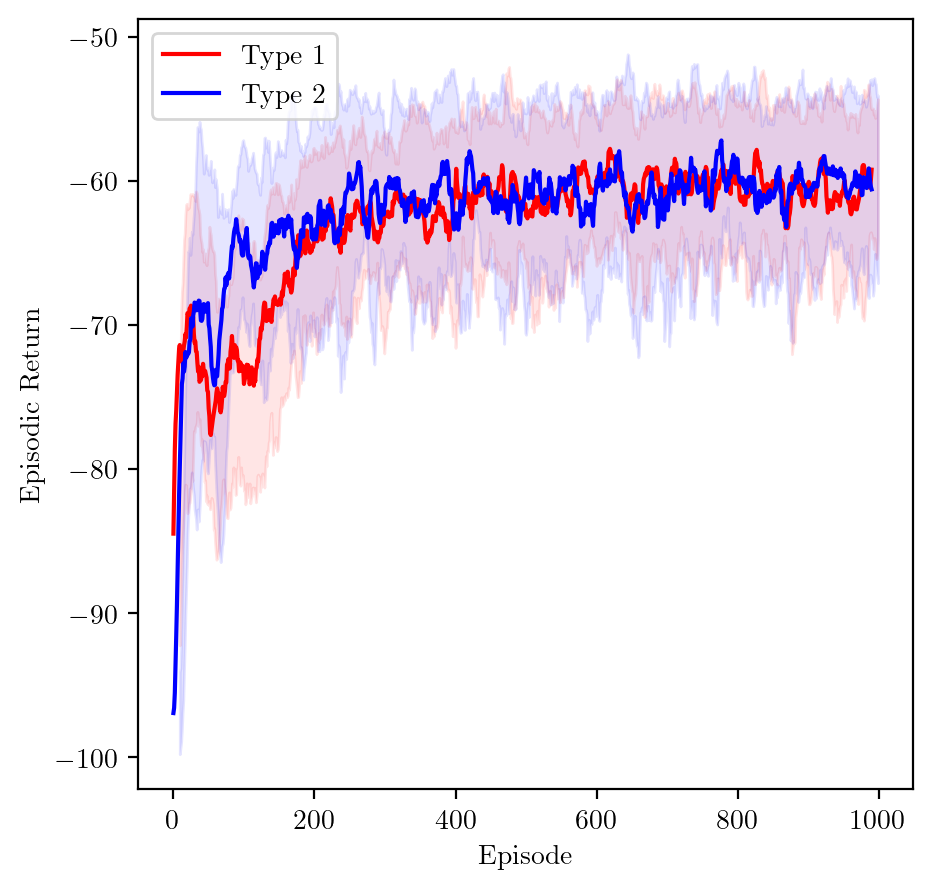

In [12]:
window_size = 10
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

type1_mean = np.mean(actobot_rewards_type1, axis=0)
type1_std = np.std(actobot_rewards_type1, axis=0)

ax.plot(np.convolve(type1_mean, np.ones(window_size)/window_size, mode='valid'), label='Type 1', color='red')
ax.fill_between(range(window_size-1, len(type1_mean)), 
                np.convolve(type1_mean - type1_std, np.ones(window_size)/window_size, mode='valid'), 
                np.convolve(type1_mean + type1_std, np.ones(window_size)/window_size, mode='valid'), alpha=0.1, color='red')

type2_mean = np.mean(actobot_rewards_type2, axis=0)
type2_std = np.std(actobot_rewards_type2, axis=0)

ax.plot(np.convolve(type2_mean, np.ones(window_size)/window_size, mode='valid'), label='Type 2', color='blue')
ax.fill_between(range(window_size-1, len(type2_mean)), 
                np.convolve(type2_mean - type2_std, np.ones(window_size)/window_size, mode='valid'), 
                np.convolve(type2_mean + type2_std, np.ones(window_size)/window_size, mode='valid'), alpha=0.1, color='blue')

ax.set_xlabel('Episode')
ax.set_ylabel('Episodic Return')
ax.legend(loc='upper left')
fig.savefig(f'result/acrobot_{args.algorithm}_48_12.pdf', bbox_inches='tight')

---

In [ ]:
# log = pd.DataFrame(columns = ['environment', 'type', 'average_reward', 'replay_size', 'update_steps', 'hidden_size', 'reward_array'])

In [ ]:
# # for hidden_size in hidden_sizes:
#     # for replay_size in replay_sizes:
# for update_step in update_steps:
#     args = Args()
#     args.env = 'CartPole'
#     # args.hidden_size = hidden_size
#     # args.replay_size = replay_size
#     args.update_steps = update_step

#     set_seed(args.seed)
#     agent = Agent(args, 'type1')
#     rewards_type1 = agent.train()

#     # store = {
#     #     'environment': args.env,
#     #     'type': 'type1',
#     #     'average_reward': np.mean(rewards),
#     #     'replay_size': args.replay_size,
#     #     'update_steps': args.update_steps,
#     #     'hidden_size': args.hidden_size,
#     #     # 'reward_array': rewards,
#     # }
#     # log = pd.concat([log, pd.DataFrame(store, index=[0])])

#     set_seed(args.seed)
#     agent = Agent(args, 'type2')
#     rewards_type2 = agent.train()

#     # store = {
#     #     'environment': args.env,
#     #     'type': 'type2',
#     #     'average_reward': np.mean(rewards),
#     #     'replay_size': args.replay_size,
#     #     'update_steps': args.update_steps,
#     #     'hidden_size': args.hidden_size,
#     #     # 'reward_array': rewards,
#     # }
#     # log = pd.concat([log, pd.DataFrame(store, index=[0])])
    
#     # log.to_csv('result/dueling_dqn.csv', index=False)

#     window_size = 10
#     fig = plt.figure(figsize=(10, 5))
#     ax = fig.add_subplot(111)

#     type1_mean = np.mean(rewards_type1, axis=0)
#     type1_std = np.std(rewards_type1, axis=0)

#     ax.plot(np.convolve(type1_mean, np.ones(window_size)/window_size, mode='valid'), label='Type 1', color='red')
#     ax.fill_between(range(window_size-1, len(type1_mean)), 
#                     np.convolve(type1_mean - type1_std, np.ones(window_size)/window_size, mode='valid'), 
#                     np.convolve(type1_mean + type1_std, np.ones(window_size)/window_size, mode='valid'), alpha=0.1, color='red')

#     type2_mean = np.mean(rewards_type2, axis=0)
#     type2_std = np.std(rewards_type2, axis=0)

#     ax.plot(np.convolve(type2_mean, np.ones(window_size)/window_size, mode='valid'), label='Type 2', color='blue')
#     ax.fill_between(range(window_size-1, len(type2_mean)), 
#                     np.convolve(type2_mean - type2_std, np.ones(window_size)/window_size, mode='valid'), 
#                     np.convolve(type2_mean + type2_std, np.ones(window_size)/window_size, mode='valid'), alpha=0.1, color='blue')

#     ax.set_xlabel('Episode')
#     ax.set_ylabel('Episodic Return')
#     ax.legend(loc='upper left')
#     fig.savefig(f'result/cartpole_{args.algorithm}_64_{args.update_steps}.pdf', bbox_inches='tight')

In [ ]:
# # for hidden_size in hidden_sizes:
# #     for replay_size in replay_sizes:
# best_type1 = 0
# for update_step in update_steps:
#     args = Args()
#     args.env = 'Acrobot'
#     # args.hidden_size = hidden_size
#     # args.replay_size = replay_size
#     args.update_steps = update_step

#     set_seed(args.seed)
#     agent = Agent(args, 'type1')
#     rewards_type1 = agent.train()

#     # store = {
#     #     'environment': args.env,
#     #     'type': 'type1',
#     #     'average_reward': np.mean(rewards),
#     #     'replay_size': args.replay_size,
#     #     'update_steps': args.update_steps,
#     #     'hidden_size': args.hidden_size,
#     #     # 'reward_array': rewards,
#     # }
#     # log = pd.concat([log, pd.DataFrame(store, index=[0])])

#     set_seed(args.seed)
#     agent = Agent(args, 'type2')
#     rewards_type2 = agent.train()

#     # store = {
#     #     'environment': args.env,
#     #     'type': 'type2',
#     #     'average_reward': np.mean(rewards),
#     #     'replay_size': args.replay_size,
#     #     'update_steps': args.update_steps,
#     #     'hidden_size': args.hidden_size,
#     #     # 'reward_array': rewards,
#     # }
#     # log = pd.concat([log, pd.DataFrame(store, index=[0])])

#     # log.to_csv('result/dueling_dqn.csv', index=False)


#     window_size = 10
#     fig = plt.figure(figsize=(5, 5))
#     ax = fig.add_subplot(111)

#     type1_mean = np.mean(rewards_type1, axis=0)
#     type1_std = np.std(rewards_type1, axis=0)

#     ax.plot(np.convolve(type1_mean, np.ones(window_size)/window_size, mode='valid'), label='Type 1', color='red')
#     ax.fill_between(range(window_size-1, len(type1_mean)), 
#                     np.convolve(type1_mean - type1_std, np.ones(window_size)/window_size, mode='valid'), 
#                     np.convolve(type1_mean + type1_std, np.ones(window_size)/window_size, mode='valid'), alpha=0.1, color='red')

#     type2_mean = np.mean(rewards_type2, axis=0)
#     type2_std = np.std(rewards_type2, axis=0)

#     ax.plot(np.convolve(type2_mean, np.ones(window_size)/window_size, mode='valid'), label='Type 2', color='blue')
#     ax.fill_between(range(window_size-1, len(type2_mean)), 
#                     np.convolve(type2_mean - type2_std, np.ones(window_size)/window_size, mode='valid'), 
#                     np.convolve(type2_mean + type2_std, np.ones(window_size)/window_size, mode='valid'), alpha=0.1, color='blue')

#     ax.set_xlabel('Episode')
#     ax.set_ylabel('Episodic Return')
#     ax.legend(loc='upper left')
#     fig.savefig(f'result/acrobot_{args.algorithm}_48_{args.update_steps}.pdf', bbox_inches='tight')
#     plt.close()

#     print(f'{args.update_steps}, Type 1 = {np.mean(type1_mean)}, Type 2 = {np.mean(type2_mean)}')
#     if np.mean(type1_mean) >= best_type1:
#         best_type1 = np.mean(type1_mean)
#         np.save(f'result/acrobot_{args.algorithm}_48_type1.npy', rewards_type1)
#         np.save(f'result/acrobot_{args.algorithm}_48_type2.npy', rewards_type2)

In [ ]:
# log.to_csv('result/dueling_dqn.csv', index=False)

---